In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import List, Literal, Annotated, TypedDict
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
generator_llm = ChatOpenAI(
    model="gpt-3.5-turbo"
)
evaluator_llm = ChatOpenAI(
    model="gpt-3.5-turbo"
)
optimizer_llm = ChatOpenAI(
    model="gpt-3.5-turbo"
)

In [27]:
class TweetEvaluationSchema(BaseModel):

    evaluation: Literal["approved", "needs_improvement"] = Field(description="Final evaluation result.")
    feedback: str = Field(description="Give Feeback for the given tweet")

In [28]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluationSchema)

f:\Gen AI Repos\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:2067: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [29]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[List[str], operator.add]
    feedback_history: Annotated[List[str], operator.add]


In [30]:
def generate_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
            Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

            Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english
            """)
    ]
    result = generator_llm.invoke(messages).content

    return {"tweet": result, "tweet_history": [result]}




In [31]:
def evaluate_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality - Is this fresh, or have you seen it a hundred times before?  
            2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness - Is it short, sharp, and scroll-stopping?  
            4. Virality Potential - Would people retweet or share it?  
            5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses 
            """)
    ]

    result = structured_evaluator_llm.invoke(messages)

    return {"evaluation": result.evaluation, "feedback": result.feedback, "feedback_history": [result.feedback]}

In [32]:
def optimise_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)
    ]

    result = optimizer_llm.invoke(messages).content
    iteration = state["iteration"] + 1

    return {"tweet": result, "tweet_history": result, "iteration": iteration}

In [33]:
def route_evaluation(state: TweetState):

    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iteration"]:
        return "approved"
    else:
        return "needs_improvement"

In [34]:
graph = StateGraph(TweetState)

graph.add_node("generate_tweet", generate_tweet)
graph.add_node("evaluate_tweet", evaluate_tweet)
graph.add_node("optimise_tweet", optimise_tweet)

graph.add_edge(START, "generate_tweet")
graph.add_edge("generate_tweet", "evaluate_tweet")
graph.add_conditional_edges("evaluate_tweet", route_evaluation, {"approved": END, "needs_improvement": "optimise_tweet"})

graph.add_edge("optimise_tweet", "evaluate_tweet")

workflow = graph.compile()

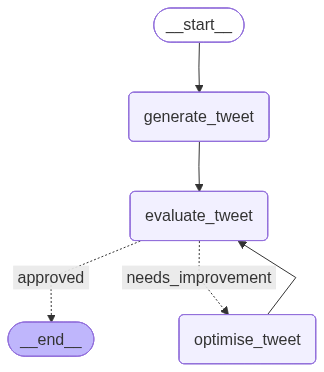

In [35]:
workflow


In [36]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [37]:
result

{'topic': 'srhberhb',
 'tweet': '"Trying to pronounce \'srhberhb\' is like attempting to decode ancient hieroglyphics with a hangover. Just another mysterious word that defies all logic and leaves us all scratching our heads like confused cats. 🤷\u200d♂️🔍 #linguisticpuzzles"',
 'evaluation': 'approved',
 'feedback': 'This tweet is approved for its originality, humor, punchiness, and format. The analogy of trying to pronounce a jumble of letters to decoding ancient hieroglyphics with a hangover is clever and funny. The comparison to scratching heads like confused cats adds an additional layer of humor. The use of emojis and the hashtag #linguisticpuzzles enhances the engagement potential. The tweet is concise, well-structured, and likely to be shared for its relatable and amusing content.',
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['"Trying to pronounce \'srhberhb\' is like attempting to decode ancient hieroglyphics with a hangover. Just another mysterious word that defie